#### Introduction

- env = gym.make("Pendulum-v0")

#### Method
Add batch normalization

In [1]:
import tensorflow as tf
import numpy as np
import gym

# reproducible
np.random.seed(1)
tf.set_random_seed(1)

#### Build A Noliner Function
#### 构建一个非线性函数

In [2]:
def y_fun( x ):
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    return np.cos(x0) + x1**2 + x1*x2 + np.sin(x3) + x4**3 +x4*x5*x6**2

#### DDPG Algorithm

In [3]:
"""
View more on the tutorial page: https://morvanzhou.github.io/tutorials/
"""

import tensorflow as tf
import numpy as np
import gym

# reproducible
np.random.seed(1)
tf.set_random_seed(1)
#####################  hyper parameters  ####################


MAX_EP_STEPS = 500
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

RENDER = False

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self):
        self.memory = np.zeros((MEMORY_CAPACITY, 7+1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
#         self.var = 3.0
        # self.a_replace_counter, self.c_replace_counter = 0, 0

#         self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,

        self.x_dim = x_dim = 7
        self.one = tf.placeholder(tf.float32, [None, 1], 'one')
#         self.x = tf.placeholder(tf.float32, [None, x_dim], 'x')
        self.y = tf.placeholder(tf.float32, [None, 1], 'y')

        with tf.variable_scope('Actor'):
            self.x = self.build_a_nn(self.one, scope='eval', trainable=True)
#             a_ = self.build_a_nn(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            y = self.build_c_nn(self.x, scope='eval', trainable=True)

        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
            
        td_error = tf.losses.mean_squared_error(labels=(self.y), predictions=y)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, name="adam-ink",  var_list = self.ce_params)

        a_loss = - tf.reduce_mean(y)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

       

    def choose_action(self, s):
#         a = self.sess.run(self.x, {self.one: s[np.newaxis, :]})[0]
        a = self.sess.run(self.x, {self.one: [[1.]]})[0]
#         a = np.clip(np.random.normal(a, self.var), -2, 2)
        
        return a

    def learn(self):
        # soft target replacement
#         self.sess.run(self.soft_replace)

        indices = np.random.choice( min(MEMORY_CAPACITY, self.pointer) , size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bx = bt[:, :7]
        by = bt[:, -1:]

        self.sess.run(self.atrain, {self.one: np.ones( (32,1) ) })
        self.sess.run(self.ctrain, {self.x: bx, self.y: by })

    def store_transition(self, x,y):
        trans = np.hstack( (x, y) )
        
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1

        if self.pointer > 100:
            self.learn()
            
    def build_a_nn(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 30, activation = tf.nn.relu, name = 'l1', trainable = trainable)
            l2 = tf.layers.dense(l1, 30, activation = tf.nn.relu, name = 'l2', trainable = trainable)
            a = tf.layers.dense(l2, self.x_dim, name = 'a', trainable = trainable)     
            return a #tf.multiply(a, self.a_bound, name = "scaled_a")  
    def build_c_nn(self, x, scope, trainable):
        # Critic Q-leaning
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(x, 30, activation = tf.nn.relu, name = 'l1', trainable = trainable)
            l2 = tf.layers.dense(l1, 30, activation = tf.nn.relu, name = 'l2', trainable = trainable)
            y = tf.layers.dense(l2, 1, name = 'a', trainable = trainable)     
            return y #tf.multiply(a, self.a_bound, name = "scaled_a")  

    
###############################  training  ####################################


In [4]:
agent = DDPG()

In [5]:
for i in range(100):
    x = np.random.rand(7)*100
#     print("x: ", x)
    y = y_fun(x)
    
    agent.store_transition(x, y)

In [6]:
from tqdm import trange

In [8]:
best_value_save = []

In [9]:
for i in trange(1000):
    x = np.random.rand(7)*100
#     print("x: ", x)
    y = y_fun(x)
    
    agent.store_transition(x, y)
    
    if (i+1)%10 == 0:
        x = agent.choose_action( [1.] )
        print("i: ", i, "best value: ", y_fun(x))
        best_value_save.append( y_fun(x) )

 10%|▉         | 99/1000 [00:00<00:01, 483.30it/s]

i:  9 best value:  0.924077419718
i:  19 best value:  0.869085793682
i:  29 best value:  0.858021008987
i:  39 best value:  0.948468419885
i:  49 best value:  1.4203297228
i:  59 best value:  3.02580809309
i:  69 best value:  8.02650587224
i:  79 best value:  23.5415521335
i:  89 best value:  72.4609008752
i:  99 best value:  225.290378809
i:  109 best value:  691.542532641


 20%|██        | 201/1000 [00:00<00:01, 492.71it/s]

i:  119 best value:  2058.29662817
i:  129 best value:  5864.15517934
i:  139 best value:  15900.3312718
i:  149 best value:  40903.8955189
i:  159 best value:  100219.032767
i:  169 best value:  234507.254711
i:  179 best value:  526385.295351
i:  189 best value:  1137249.47535
i:  199 best value:  2369087.35427
i:  209 best value:  4775964.98356


 31%|███       | 311/1000 [00:00<00:01, 510.14it/s]

i:  219 best value:  9333796.42469
i:  229 best value:  17693480.3945
i:  239 best value:  32621001.6168
i:  249 best value:  58651263.7903
i:  259 best value:  103207141.326
i:  269 best value:  178015948.98
i:  279 best value:  301159122.918
i:  289 best value:  500467081.73
i:  299 best value:  816583890.9
i:  309 best value:  1307567593.7
i:  319 best value:  2058047882.7
i:  329 best value:  3188633043.44


 42%|████▏     | 415/1000 [00:00<00:01, 510.33it/s]

i:  339 best value:  4873399644.74
i:  349 best value:  7358028282.67
i:  359 best value:  10987326731.3
i:  369 best value:  16227034120.9
i:  379 best value:  23682983544.9
i:  389 best value:  34149538824.3
i:  399 best value:  48711199970.4
i:  409 best value:  68796592757.6
i:  419 best value:  96170516319.1
i:  429 best value:  133080986558.0
i:  439 best value:  182446205757.0


 52%|█████▏    | 522/1000 [00:01<00:00, 514.14it/s]

i:  449 best value:  247926845067.0
i:  459 best value:  334142105379.0
i:  469 best value:  446999084099.0
i:  479 best value:  593770867496.0
i:  489 best value:  783161783307.0
i:  499 best value:  1.02599575974e+12
i:  509 best value:  1.33596187092e+12
i:  519 best value:  1.72932365321e+12
i:  529 best value:  2.22488838691e+12
i:  539 best value:  2.84554428288e+12
i:  549 best value:  3.61892423521e+12


 63%|██████▎   | 633/1000 [00:01<00:00, 516.95it/s]

i:  559 best value:  4.57693325874e+12
i:  569 best value:  5.75608368112e+12
i:  579 best value:  7.20019005675e+12
i:  589 best value:  8.96523195557e+12
i:  599 best value:  1.11161010995e+13
i:  609 best value:  1.37277701952e+13
i:  619 best value:  1.68924378455e+13
i:  629 best value:  2.07137840558e+13
i:  639 best value:  2.53167899546e+13
i:  649 best value:  3.08464498253e+13
i:  659 best value:  3.7445811806e+13


 74%|███████▍  | 738/1000 [00:01<00:00, 516.68it/s]

i:  669 best value:  4.52712907864e+13
i:  679 best value:  5.45230439919e+13
i:  689 best value:  6.54440310566e+13
i:  699 best value:  7.8290469989e+13
i:  709 best value:  9.33415447729e+13
i:  719 best value:  1.10956964381e+14
i:  729 best value:  1.31555006884e+14
i:  739 best value:  1.55564469897e+14
i:  749 best value:  1.83432357968e+14
i:  759 best value:  2.15749310302e+14
i:  769 best value:  2.53177193896e+14


 84%|████████▍ | 842/1000 [00:01<00:00, 515.31it/s]

i:  779 best value:  2.96358864251e+14
i:  789 best value:  3.45933223123e+14
i:  799 best value:  4.02740548855e+14
i:  809 best value:  4.67704763066e+14
i:  819 best value:  5.41860988785e+14
i:  829 best value:  6.26403705337e+14
i:  839 best value:  7.22548815653e+14
i:  849 best value:  8.31651901358e+14
i:  859 best value:  9.55342424155e+14
i:  869 best value:  1.09538563607e+15


 95%|█████████▍| 946/1000 [00:01<00:00, 512.86it/s]

i:  879 best value:  1.25359579515e+15
i:  889 best value:  1.43192810988e+15
i:  899 best value:  1.63248937073e+15
i:  909 best value:  1.85731754479e+15
i:  919 best value:  2.10859350203e+15
i:  929 best value:  2.38853070951e+15
i:  939 best value:  2.69926469594e+15
i:  949 best value:  3.04383050831e+15
i:  959 best value:  3.42535656177e+15
i:  969 best value:  3.84787792252e+15
i: 

100%|██████████| 1000/1000 [00:01<00:00, 508.93it/s]

 979 best value:  4.31693823044e+15
i:  989 best value:  4.8365578849e+15
i:  999 best value:  5.40963262196e+15


In [10]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
all_reward = best_value_save

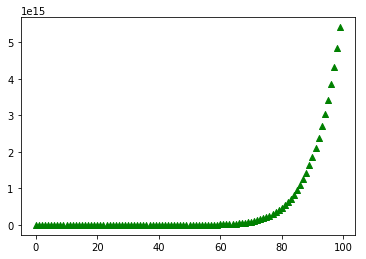

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.show()